- Table of contents
  - Reading and understanding the data
  - Preperation of data for modeling
  - Training the model
  - Tuning the model
  - Residual Analysis
  - prediction and evaluation

# Reading and understanding the data

In [98]:
# importing libraries

import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [99]:
# importing data 
df= pd.read_csv('https://cdn.upgrad.com/uploads/production/b7624eea-49ad-40e3-8bb6-6f6c0164d14b/day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [101]:
# basic data cleaning procedure

# drop duplicates
df=df.drop_duplicates()



In [102]:
# now checking each columns to see how many null values they contain
for c in df.columns:
  percent=(df[c].isna().sum()/len(df[c]))*100
  print(c," total junk values %",percent," : ",df[c].isna().sum())

instant  total junk values % 0.0  :  0
dteday  total junk values % 0.0  :  0
season  total junk values % 0.0  :  0
yr  total junk values % 0.0  :  0
mnth  total junk values % 0.0  :  0
holiday  total junk values % 0.0  :  0
weekday  total junk values % 0.0  :  0
workingday  total junk values % 0.0  :  0
weathersit  total junk values % 0.0  :  0
temp  total junk values % 0.0  :  0
atemp  total junk values % 0.0  :  0
hum  total junk values % 0.0  :  0
windspeed  total junk values % 0.0  :  0
casual  total junk values % 0.0  :  0
registered  total junk values % 0.0  :  0
cnt  total junk values % 0.0  :  0


It seems like there are no null values. so we can proceed further.

In [103]:
if len(df.instant.unique())==len(df.instant):
  print("column instant can be used as index")

column instant can be used as index


In [104]:
df.set_index('instant',inplace=True)
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [105]:
# lets analyse numeric variables
num_vars=['temp','atemp','hum','windspeed','cnt']

In [106]:
df[num_vars].corr()

,temp,atemp,hum,windspeed,cnt
temp,1.000000,0.991696,0.128565,-0.158186,0.627044
atemp,0.991696,1.000000,0.141512,-0.183876,0.630685
hum,0.128565,0.141512,1.000000,-0.248506,-0.098543
windspeed,-0.158186,-0.183876,-0.248506,1.000000,-0.235132
cnt,0.627044,0.630685,-0.098543,-0.235132,1.000000


<Figure size 864x576 with 0 Axes>

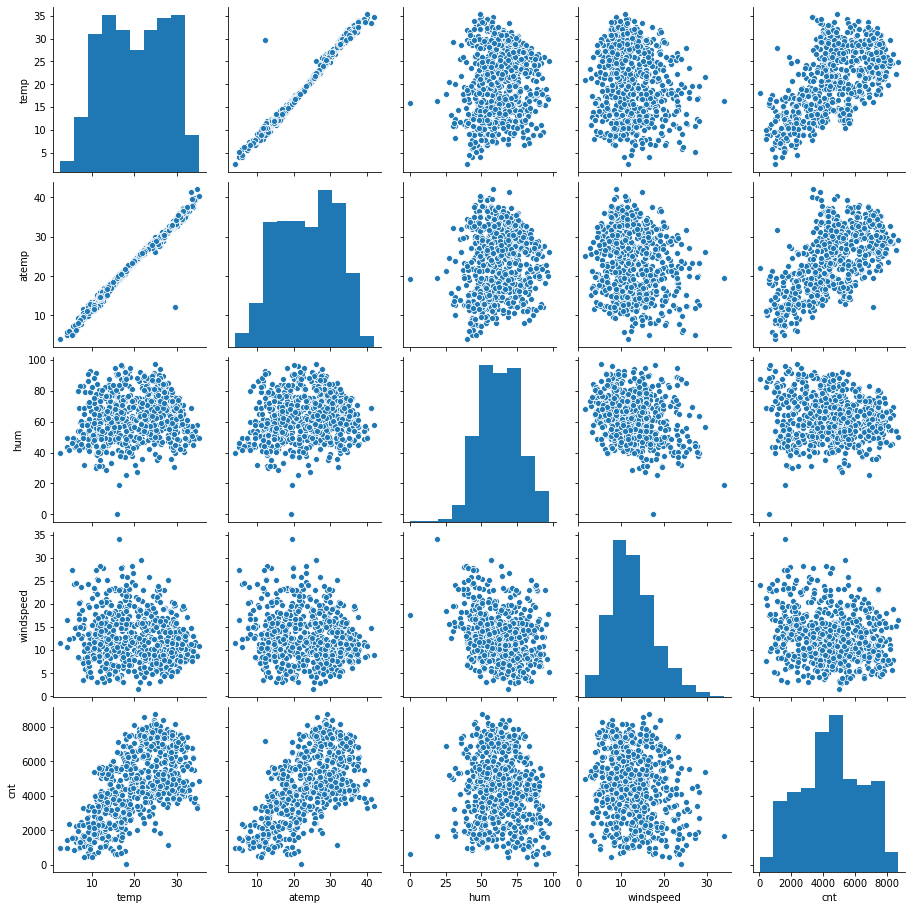

In [107]:
# understanding the co relation between the variables

plt.figure(figsize=(12,8))
sns.pairplot(df[num_vars])
plt.show()

We found that the cnt has some positive relation with temp and atemp. <br>
We also found that the variables temp and atemp are highly co related hence one of them may need to be dropped for further analysis due to multicolinearity

In [108]:
# analyse categorical variable

# before analysing categorical variables we need to map it correctly as 
# specified on https://cdn.upgrad.com/uploads/production/0fdfa494-a9bf-4b32-873f-900e3b262948/Readme.txt

df['season']=df.season.apply(lambda x:{1:'spring', 2:'summer', 3:'fall', 4:'winter'}[x])
df['weathersit']=df.weathersit.apply(lambda x:{
    1: 'Clear, Few clouds, Partly cloudy, Partly cloudy',
		2: 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
		3: 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
		4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog',
}[x])

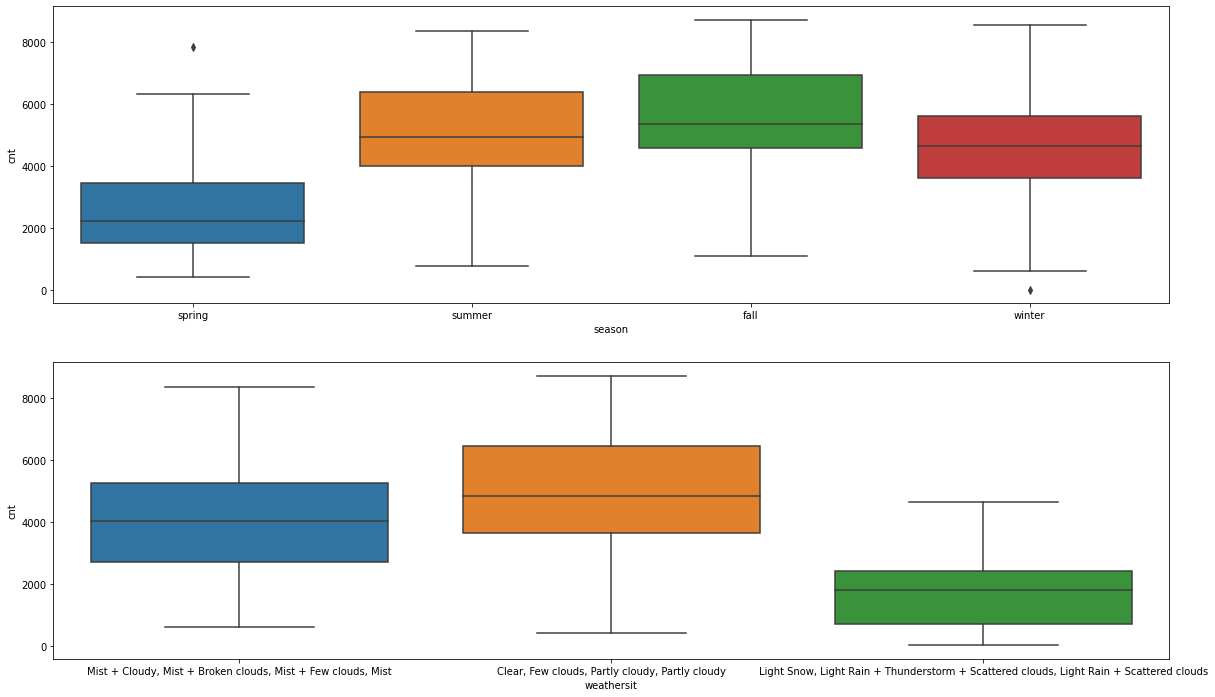

In [109]:
plt.figure(figsize=(20, 12))
plt.subplot(2,1,1)
sns.boxplot(x = 'season', y = 'cnt', data = df)
plt.subplot(2,1,2)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df)
plt.show()

We have found that  the season **fall** has the major **cnt** <br>
we also found that the cnt is more disributed when **weather** is **Clear, Few clouds, Partly cloudy, Partly cloudy**

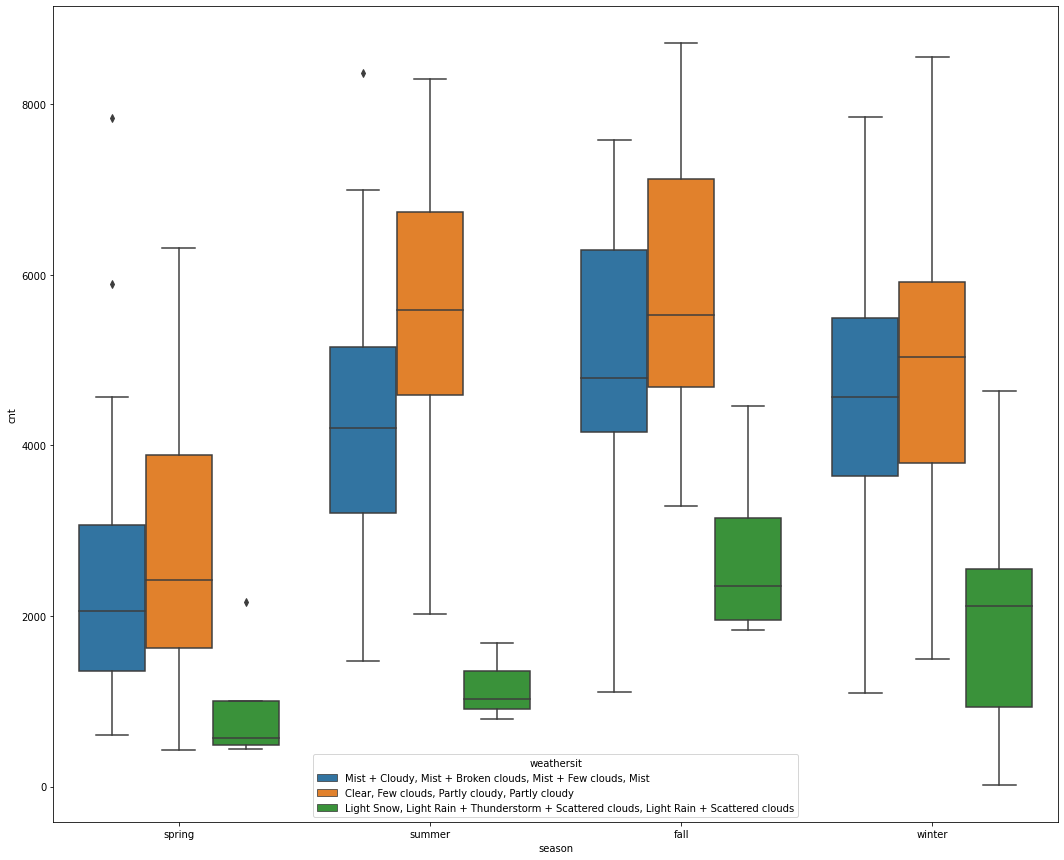

In [110]:
# lets analyse them together as parallel 

plt.figure(figsize = (18, 15))
sns.boxplot(x = 'season', y = 'cnt', hue = 'weathersit', data = df)
plt.show()

The above graph explains similar result as the previous graph and these two categorical variables could be good predictors for regression.

# Preperation of data for modeling

In [111]:
# we will need to handle the categorical variables by creating dummy varaibles as below

season_dummy=pd.get_dummies(df['season'],drop_first=True)
weathersit_dummy=pd.get_dummies(df['weathersit'],drop_first=True)

df=pd.concat([df,season_dummy,weathersit_dummy],axis=1)

# removing redundant information
df=df.drop(columns=['season','weathersit'])


# removing the casual and registered becuase indirectly it is what we want to predict
df=df.drop(columns=['casual','registered'])


# droping date column becuase we already have derived column such as month , weekday, weekend etc
df=df.drop(columns='dteday')

# Alternate way
# Converting datatime to ordinal variable so that it can be used in doing regression
# import datetime as dt
# df['dteday'] = pd.to_datetime(df['dteday'])
# df['dteday']=df['dteday'].map(dt.datetime.toordinal)

# creating the dummy variables for month by dividing the year in 4 equal parts quater 1,quater 2,quater 3 and quater 4
# def monthtocat(x):
#   v=''
#   if x>=1 and x<4:
#     v='Q1' #January, February, and March (Q1)
#   elif x>=5 and x<7:
#     v='Q2' #April, May, and June (Q2)
#   elif x>=7 and x<10:
#     v='Q3' #July, August, and September (Q3)
#   else:
#     v='Q4' #October, November, and December (Q4)
#   return v

# df.mnth=df.mnth.apply(lambda x:monthtocat(x))
# mnth_dummy=pd.get_dummies(df['mnth'],drop_first=True)
# df=pd.concat([df,mnth_dummy],axis=1)
# df=df.drop(columns=['mnth'])

# creating dummy variables for weekdays 

# df.weekday=df.weekday.apply(lambda x:{
#         0:'Monday',
#         1:'Tuesday',
#         2:'Wednesday',
#         3:'Thursday',
#         4:'Friday',
#         5:'Saturday',
#         6:'Sunday',    
#     }[x])

# weekday_dummy=pd.get_dummies(df['weekday'],drop_first=True)

# df=pd.concat([df,weekday_dummy],axis=1)
# df=df.drop(columns=['weekday'])

df.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,"Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds","Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist"
instant,,,,,,,,,,,,,,,
1,0,1,0,6,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,1
2,0,1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,1
3,0,1,0,1,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0
4,0,1,0,2,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0
5,0,1,0,3,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0


In [112]:
# lets split the data for training and testing purpose with a 7:3 ratio

dftrain,dftest=train_test_split(df,train_size=0.7,random_state=100)
print(dftrain.shape)
print(dftest.shape)

(510, 15)
(220, 15)


# Training the model

In [113]:
# As the data is almost ready lets create our model
ytrain = df.pop('cnt')
xtrain = df

#add constant 
xtrain_sm=sm.add_constant(xtrain)

#create first model
lr=sm.OLS(ytrain,xtrain_sm)

#fit the model
lr_model=lr.fit()


lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     246.2
Date:                Sat, 29 Aug 2020   Prob (F-statistic):          3.22e-262
Time:                        15:16:28   Log-Likelihood:                -5917.3
No. Observations:                 730   AIC:                         1.186e+04
Df Residuals:                     715   BIC:                         1.193e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================================
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                    2209.8445    310.162      7.125      0.000    1600.908    2818.781
yr                                                                                       2024.3106     60.925     33.226      0.000    1904.697    2143.924
mnth                                                                                      -16.1643     16.117     -1.003      0.316     -47.808      15.479
holiday                                                                                  -531.5996    186.897     -2.844      0.005    -898.533    -164.667
weekday                                                                                    67.6248     15.138      4.467      0.000      37.904      97.346
workingday                                                                                119.4323     66.964      1.784      0.075     -12.037     250.901
temp                                                                                       95.3648     33.598      2.838      0.005      29.402     161.327
atemp                                                                                      26.5998     30.082      0.884      0.377     -32.460      85.660
hum                                                                                       -11.7114      2.941     -3.982      0.000     -17.485      -5.937
windspeed                                                                                 -40.4021      6.401     -6.312      0.000     -52.968     -27.836
spring                                                                                   -913.8511    164.807     -5.545      0.000   -1237.414    -590.288
summer                                                                                    234.5672    109.921      2.134      0.033      18.761     450.373
winter                                                                                    732.1049    131.513      5.567      0.000     473.907     990.303
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds -1960.1535    204.973     -9.563      0.000   -2362.575   -1557.732
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                             -449.7736     80.379     -5.596      0.000    -607.581    -291.966
==============================================================================
Omnibus:                       98.706   Durbin-Watson:                   1.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.383
Skew:                          -0.735 

As this was our first model without any filteration on predictor variable it was obvious that the model will not be a good model.
Although R^2 and adjusted r^2 are good but F-statistic tells a different story. Also there is multicolinearity that needs to be handled. <br>Now we will proceed further and tune the model.

# Tuning the model

There are two ways to select features, either manually checking each variable or using automated techniques such as Recursive Feature Elimination (RFE).<br>
We will use both the method, first we will use RFE and then do manualy elimination to get the optimal solution.

In [114]:
#we will use recursive feature elimination to chose the best 12 feature for our regression

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
lm=LinearRegression()
lm.fit(xtrain,ytrain)
rfe=RFE(lm,12)
rfe=rfe.fit(xtrain,ytrain)
list(zip(xtrain.columns,rfe.support_,rfe.ranking_))


[('yr', True, 1),
 ('mnth', True, 1),
 ('holiday', True, 1),
 ('weekday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 2),
 ('hum', False, 3),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
  True,
  1),
 ('Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist', True, 1)]

In [115]:
 
 # create a function to print vif
 def printVif(x):
  vif=pd.DataFrame()
  vif['features']=x.columns
  vif['vif']=[round(variance_inflation_factor(x.values,i),2) for i in range(x.shape[1])]
  vif=vif.sort_values(by='vif',ascending=False)
  print(vif)

In [116]:
# selecting the top 12 column as per RFE
xtrain=xtrain[['yr','mnth','holiday','weekday','workingday','temp','windspeed','spring','summer','winter','Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds','Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist']]
#add constant 
xtrain_sm=sm.add_constant(xtrain)

#create first model
lr=sm.OLS(ytrain,xtrain_sm)

#fit the model
lr_model=lr.fit()


print(lr_model.summary())

printVif(xtrain)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     280.3
Date:                Sat, 29 Aug 2020   Prob (F-statistic):          3.49e-261
Time:                        15:16:28   Log-Likelihood:                -5925.5
No. Observations:                 730   AIC:                         1.188e+04
Df Residuals:                     717   BIC:                         1.194e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

As it can be noticed from the summary statistics there are various variables which are not significant in this model for example <br>variables like mnth, holiday, workingday and summer have p-value greater than equal to 5 and<br> variables like mnth, temp and windspeed have VIF greater than 5 <br>
We will handle each variable manually one by one

In [117]:
# we will drop mnth because it has a very high p-value and high VIF
xtrain=xtrain.drop(columns='mnth')
#add constant 
xtrain_sm=sm.add_constant(xtrain)

#create first model
lr=sm.OLS(ytrain,xtrain_sm)

#fit the model
lr_model=lr.fit()


print(lr_model.summary())

printVif(xtrain)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     305.3
Date:                Sat, 29 Aug 2020   Prob (F-statistic):          5.01e-262
Time:                        15:16:28   Log-Likelihood:                -5926.5
No. Observations:                 730   AIC:                         1.188e+04
Df Residuals:                     718   BIC:                         1.193e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [118]:
# we will drop workingday because it has a very high p-value 
xtrain=xtrain.drop(columns='workingday')
#add constant 
xtrain_sm=sm.add_constant(xtrain)

#create first model
lr=sm.OLS(ytrain,xtrain_sm)

#fit the model
lr_model=lr.fit()


print(lr_model.summary())

printVif(xtrain)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     334.2
Date:                Sat, 29 Aug 2020   Prob (F-statistic):          1.68e-262
Time:                        15:16:28   Log-Likelihood:                -5928.4
No. Observations:                 730   AIC:                         1.188e+04
Df Residuals:                     719   BIC:                         1.193e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [119]:
# we will drop windspeed because it has a very high VIF 
xtrain=xtrain.drop(columns='windspeed')
#add constant 
xtrain_sm=sm.add_constant(xtrain)

#create first model
lr=sm.OLS(ytrain,xtrain_sm)

#fit the model
lr_model=lr.fit()


print(lr_model.summary())

printVif(xtrain)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     352.9
Date:                Sat, 29 Aug 2020   Prob (F-statistic):          3.84e-257
Time:                        15:16:28   Log-Likelihood:                -5943.9
No. Observations:                 730   AIC:                         1.191e+04
Df Residuals:                     720   BIC:                         1.195e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

As you can see we have reached at a level where p-value of each coef is below 5% and VIF of each variable is below 5 <br>
Also it can be noticed that the r^2  is approximately around 81% which indicates that it may be a good model.

# Residual Analysis

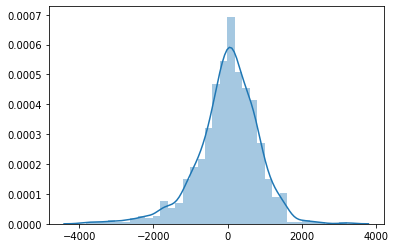

In [120]:
ytrain_pred=lr_model.predict(xtrain_sm)
res=ytrain-ytrain_pred
sns.distplot(res)

The residual has a mean of zero and it is normally distributed

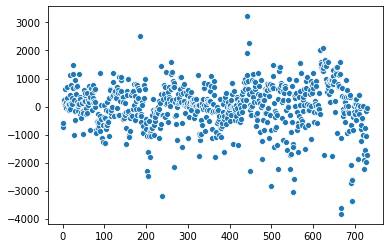

In [121]:
sns.scatterplot(data=res)

Also it can be noticed that there is no trend in the residual, it is randomly distributed. Error terms are independent

# Prediction and evaluation

In [122]:

ytest= dftest.pop('cnt')

# match variables as per the model
xtest= dftest[xtrain.columns]

# add constant
xtest_sm=sm.add_constant(xtest)

# predict
ytest_pred=lr_model.predict(xtest_sm)

In [123]:
# evaluate the model
res=r2_score(ytest,ytest_pred)
round(res*100,2)

81.64

As it can be noticed that the models r^2 with training data and testing data does not have significant difference (approximately 81%) which is why it can be safely assumed that the model which is generated is highly accurate and a good fit.

Few of the indication we get is as below
  - Holiday is negatively correlated so most of the registered users might be using bikes to commute to work
  - Also if the temperature is higher the users are more likely to register for bike-sharing
  - Over the years the trend of bike-sharing has increased.
  - In winter and summer, there are more people registering for bike-sharing